In [1]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm; tqdm.pandas()
pd.options.display.max_columns = 202
pd.options.display.max_rows = 300
import seaborn as sns
import hdbscan

In [2]:
train = pd.read_pickle('data/train_original.pkl')
test = pd.read_pickle('data/test_original.pkl')
special_cols = [col for col in train.columns if train[col].dtype != np.float64]
feature_cols = [col for col in train.columns if col not in special_cols]

train.drop(special_cols[0], axis=1, inplace=True)
test.drop(special_cols[0], axis=1, inplace=True)

unique_samples = []
unique_count = np.zeros_like(test)
for feature in tqdm(range(test.shape[1])):
    _, index_, count_ = np.unique(test.values[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

fake_test=test.loc[synthetic_samples_indexes].reset_index(drop=True)
real_test=test.loc[real_samples_indexes].reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.02it/s]


In [3]:
real_data = pd.concat([train[feature_cols], test[feature_cols]], axis=0).reset_index(drop=True)
means = real_data.mean(axis=0)
stds = real_data.std(axis=0)

In [4]:
means.index

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

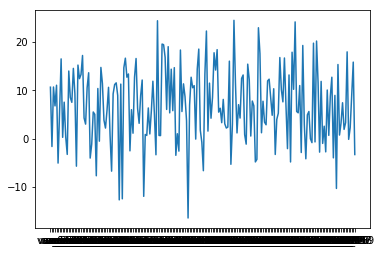

In [5]:
plt.plot(means); plt.show()

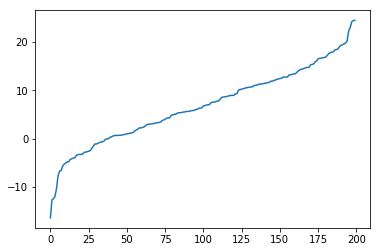

In [6]:
plt.plot(sorted(means)); plt.show()

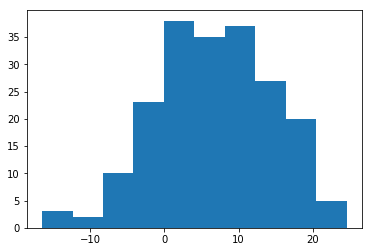

In [7]:
plt.hist(sorted(means)); plt.show()

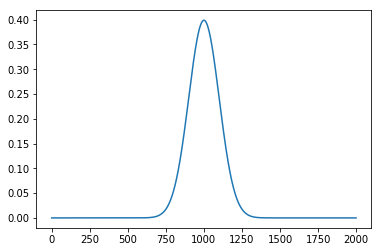

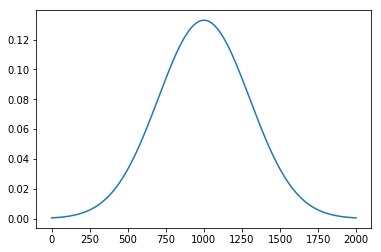

In [8]:
from scipy.stats import norm
plt.plot(norm.pdf(np.arange(-10, 10, 0.01), loc=0, scale=1)); plt.show()
plt.plot(norm.pdf(np.arange(-10, 10, 0.01), loc=0, scale=3)); plt.show()

In [9]:
means

var_0      10.669326
var_1      -1.625933
var_2      10.711322
var_3       6.792372
var_4      11.077366
var_5      -5.057938
var_6       5.412056
var_7      16.537496
var_8       0.280648
var_9       7.568322
var_10      0.382838
var_11     -3.257074
var_12     14.023320
var_13      8.535552
var_14      7.535154
var_15     14.573415
var_16      9.327466
var_17     -5.700590
var_18     15.254895
var_19     12.447621
var_20     13.294661
var_21     17.244240
var_22      4.302220
var_23      3.019623
var_24     10.575940
var_25     13.667233
var_26     -4.019427
var_27     -1.133722
var_28      5.531818
var_29      5.050560
var_30     -7.687717
var_31     10.398983
var_32     -0.518858
var_33     14.768416
var_34     11.434555
var_35      3.856314
var_36      2.200259
var_37      5.871974
var_38     10.644969
var_39      0.667811
var_40     -6.730780
var_41      9.285252
var_42     11.222044
var_43     11.569463
var_44      8.950435
var_45    -12.682881
var_46     11.313115
var_47    -12

In [10]:
stds

var_0       3.038398
var_1       4.045275
var_2       2.637393
var_3       2.048028
var_4       1.619805
var_5       7.866274
var_6       0.865652
var_7       3.421286
var_8       3.333002
var_9       1.233468
var_10      5.504734
var_11      5.965853
var_12      0.190066
var_13      4.634124
var_14      2.251584
var_15      0.411651
var_16      2.551152
var_17      6.729550
var_18      7.849175
var_19      7.993249
var_20      5.880245
var_21      8.198222
var_22      2.845989
var_23      0.527422
var_24      3.774152
var_25      0.285494
var_26      5.934143
var_27      1.524244
var_28      0.784494
var_29      2.613010
var_30      7.968380
var_31      2.158113
var_32      2.588269
var_33      4.324025
var_34      0.541326
var_35      5.175100
var_36      3.120355
var_37      2.253485
var_38      4.269866
var_39      4.073719
var_40      8.289040
var_41      5.941223
var_42      0.695411
var_43      0.309763
var_44      5.907121
var_45     21.403790
var_46      2.860739
var_47     10

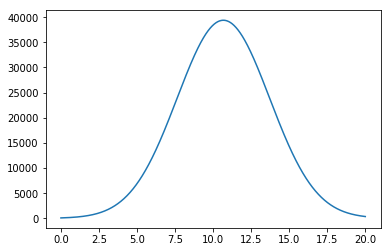

In [11]:
f = 'var_0'
plt.plot(np.arange(0, 20, 0.01), norm.pdf(np.arange(0, 20, 0.01), loc=means.loc[f], scale=stds.loc[f])*300000); plt.show()

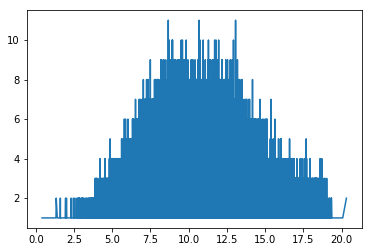

In [12]:
vc = train[f].value_counts().sort_index()
plt.plot(vc.index, vc.values); plt.show()

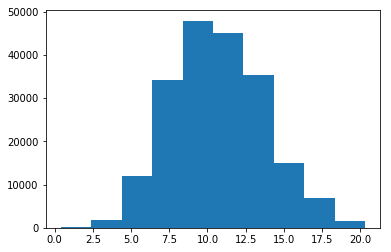

In [13]:
plt.hist(train[f]); plt.show()

In [14]:
f = 'var_0'
real_vc = train[f].append(real_test[f]).value_counts()
fake_vc = fake_test[f].value_counts()
train.loc[:, f+'_cnt'] = train[f].map(real_vc)
test.loc[real_samples_indexes, f+'_cnt'] = test.loc[real_samples_indexes, f].map(real_vc)
test.loc[synthetic_samples_indexes, f+'_cnt'] = test.loc[synthetic_samples_indexes, f].map(fake_vc)

train[f+'_norm_cnt_diff'] = norm.cdf(train[f].values+0.00005, loc=means.loc[f], scale=stds.loc[f]) - \
                             norm.cdf(train[f].values-0.00005, loc=means.loc[f], scale=stds.loc[f])
test[f+'_norm_cnt_diff'] = norm.cdf(test[f].values+0.00005, loc=means.loc[f], scale=stds.loc[f]) - \
                             norm.cdf(test[f].values-0.00005, loc=means.loc[f], scale=stds.loc[f])

train[f+'_norm_cnt_diff'] *= train.shape[0]+real_test.shape[0]
test.loc[real_samples_indexes, f+'_norm_cnt_diff'] *= train.shape[0]+real_test.shape[0]
test.loc[synthetic_samples_indexes, f+'_norm_cnt_diff'] *= fake_test.shape[0]

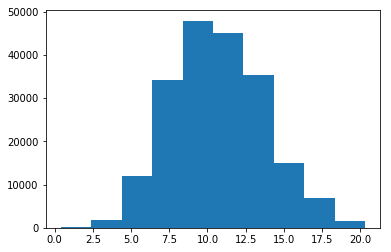

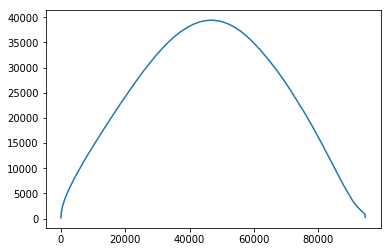

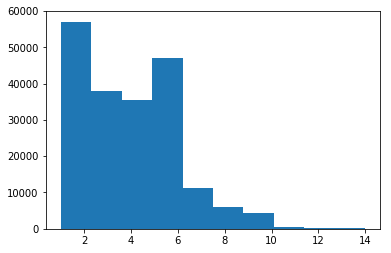

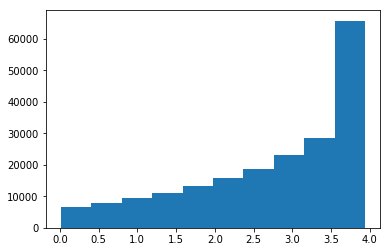

In [16]:
plt.hist(train[f]); plt.show()
plt.plot(norm.pdf(sorted(train[f].unique()), loc=means.loc[f], scale=stds.loc[f])*(train.shape[0]+real_test.shape[0])); plt.show()
plt.hist(train[f+'_cnt']); plt.show()
plt.hist(train[f+'_norm_cnt_diff']); plt.show()

In [17]:
'''
fake_test=test.loc[synthetic_samples_indexes].reset_index(drop=True)
real_test=test.loc[real_samples_indexes].reset_index(drop=True)
'''

for f in tqdm(feature_cols):
    real_vc = train[f].append(real_test[f]).value_counts()
    fake_vc = fake_test[f].value_counts()
    train.loc[:, f+'_cnt'] = train[f].map(real_vc)
    test.loc[real_samples_indexes, f+'_cnt'] = test.loc[real_samples_indexes, f].map(real_vc)
    test.loc[synthetic_samples_indexes, f+'_cnt'] = test.loc[synthetic_samples_indexes, f].map(fake_vc)
    
    train[f+'_norm_cnt_diff'] = norm.cdf(train[f].values+0.00005, loc=means.loc[f], scale=stds.loc[f]) - \
                             norm.cdf(train[f].values-0.00005, loc=means.loc[f], scale=stds.loc[f])
    test[f+'_norm_cnt_diff'] = norm.cdf(test[f].values+0.00005, loc=means.loc[f], scale=stds.loc[f]) - \
                                 norm.cdf(test[f].values-0.00005, loc=means.loc[f], scale=stds.loc[f])

    train[f+'_norm_cnt_diff'] *= train.shape[0]+real_test.shape[0]
    test.loc[real_samples_indexes, f+'_norm_cnt_diff'] *= train.shape[0]+real_test.shape[0]
    test.loc[synthetic_samples_indexes, f+'_norm_cnt_diff'] *= fake_test.shape[0]

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [09:26<00:00,  3.99s/it]


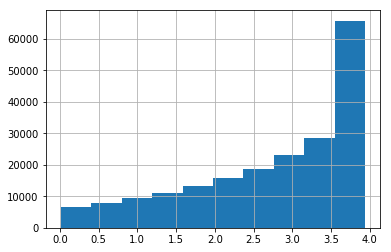

In [18]:
train['var_0_norm_cnt_diff'].hist()

In [19]:
for f in tqdm(feature_cols):
    train[f+'_norm_cnt_diff'] = train[f+'_cnt'] - train[f+'_norm_cnt_diff']
    test[f+'_norm_cnt_diff'] = test[f+'_cnt'] - test[f+'_norm_cnt_diff']

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 248.14it/s]


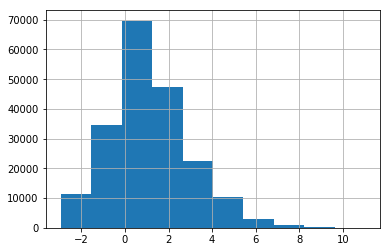

In [20]:
train['var_0_norm_cnt_diff'].hist()

In [22]:
generated_features = [f for f in train.columns if 'norm_cnt_diff' in f]
train[['target']+generated_features].iloc[:10000].corr('spearman').sort_values('target', ascending=False)[['target']]

,target
target,1.000000
var_197_norm_cnt_diff,0.033905
var_97_norm_cnt_diff,0.025217
var_22_norm_cnt_diff,0.023795
var_122_norm_cnt_diff,0.021163
var_108_norm_cnt_diff,0.020413
var_199_norm_cnt_diff,0.019881
var_9_norm_cnt_diff,0.019149
var_144_norm_cnt_diff,0.018668
var_36_norm_cnt_diff,0.017529


In [23]:
train[generated_features].to_pickle('features/cnt_diff_to_expected_norm_dist_train')
test[generated_features].to_pickle('features/cnt_diff_to_expected_norm_dist_test')